#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [ ]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [ ]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

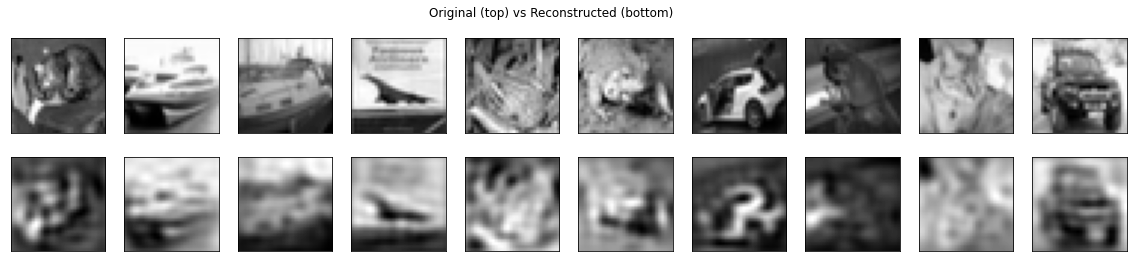

In [ ]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_

In [ ]:
def apply_svd_decomposition(encoding_dim):
  U_k = SVD(x_train, encoding_dim)

  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)

  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)

  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()

  plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)"),

  return accuracy_train, accuracy_test

In [ ]:
def print_svd_result(encoding_dim, accuracy_train, accuracy_test):
  print(f"Encoding dims: {encoding_dim}")
  print("Training mse: %.5f" % ( accuracy_train))
  print("Test mse: %.5f" % ( accuracy_test))

def plot_encodingdim_accuracy(encoding_dims, accuracy_trains, accuracy_tests):
  plt.scatter(encoding_dims, accuracy_trains, label="Accuracy train", marker="o")
  plt.scatter(encoding_dims, accuracy_tests, label="Accuracy test", marker="v")
  plt.xlabel("Encoding dimension")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

In [ ]:
encoding_dims = list(range(30, 630, 30)) + [256]

accuracy_trains = []
accuracy_tests = []

for encoding_dim in encoding_dims:
  accuracy_train, accuracy_test = apply_svd_decomposition(encoding_dim)
  accuracy_trains.append(accuracy_train)
  accuracy_tests.append(accuracy_test)

  print_svd_result(encoding_dim, accuracy_train, accuracy_test)

plot_encodingdim_accuracy(encoding_dims, accuracy_trains, accuracy_trains)

Output hidden; open in https://colab.research.google.com to view.

Varying the encoding dimension, i.e. the dimension of the encoded representation, I observed the following behaviour: for smaller encoding_dim values, the recontruted images are very bad and the error is high because we lose a lot of information, while for bigger encoding_dim values the reconstructed images are very almost the same as the original ones and the error is low. That's because smaller the dimension of compressed representation is, the feature extraction will be stronger and it will save only the most important features. With a higher compressed representation, it can save additional features beyond the most important ones and so it will be able to reconstruct better images.

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_17 (Dense)            (None, 256)               262400    
                                                                 
 dense_18 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.2110 - val_loss: 0.0313
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 3/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.0173
Epoch 4/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 5/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0135 - val_loss: 0.0123
Epoch 6/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 7/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 8/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 9/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 10/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 11/15
79/79 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0055 - 571ms/epoch - 2ms/step
Test mse: 0.00554


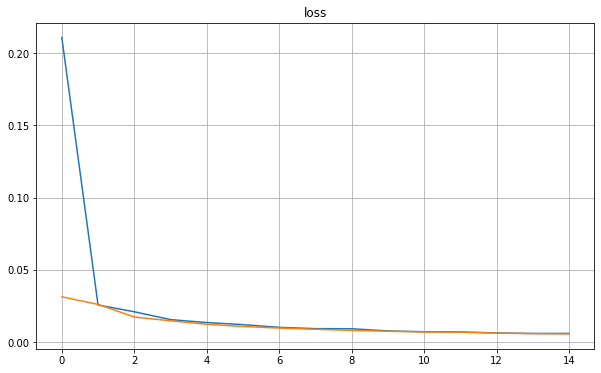

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

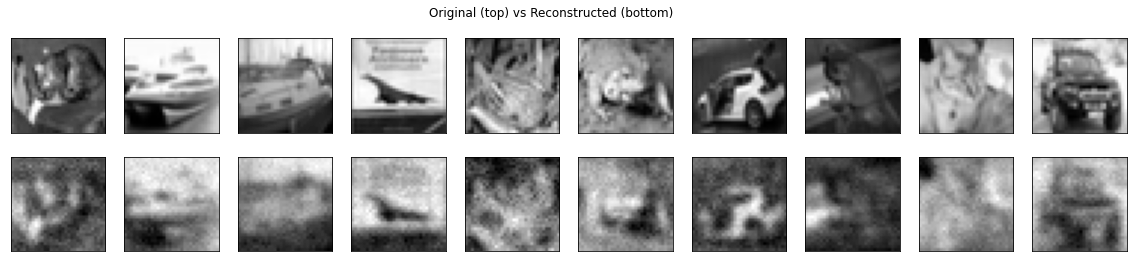

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_
The results obtained on the shallow linear autoencoder and the SVD, with an ENCODING_DIM set to 256, are very close, even if the error got in the SVD is slighly better than the one got with the autoencoder, with $0.00153$ vs $0.00589$. 

The neural network defined above it's related to the SVD decomposition thanks to the fact that both of them perform linear dimensionality reduction. Indeed, shallow linear autoencoders map the input space to a smaller space and then again to another space with the same dimensionality as the first one, exploiting linear activation functions. This sequence of operations is very close to what SVD does, even if the SVD is a deterministic procedure, while the autoencoder not. Moreover, the coordinates of the output of the autoencoder are
correlated and aren't sorted in descending order of variance, fact that happens in SVD.

From a mathematical point of view, the previous claim can be proved in the following way: given that we have a shallow linear autoencoder, let $z = f_1(W_1 X)$ be the outpur of the first layer and $\hat{X} = f_2(W_2 z)$ be the output of the network.

The goal is to minimize the reconstructed error: $\min_{W_1, W_2} \frac{1}{n} {\lVert X - \hat{X} \rVert_2^2}$,

which becomes such error since $f_1$ and $f_2$ are linear: $\min_{W_1, W_2} \frac{1}{n} {\lVert X - W_1 W_2 X \rVert_2^2}$. 

Thus, we want to solve the equation $X - W_1 W_2 X = 0$, that has a solution $X = W_1 W_2 X \iff W_1 = W_2^T$, so we can rewrite $X = W_2 W_2^T X$ which is exactly the same thing we do in SVD since it tries to reconstruct the original input from the learned encoded representation $W_2$.


##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_19 (Dense)            (None, 256)               262400    
                                                                 
 dense_20 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.1110 - val_loss: 0.0589
Epoch 2/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0479 - val_loss: 0.0420
Epoch 3/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0379 - val_loss: 0.0327
Epoch 4/15
79/79 [=====

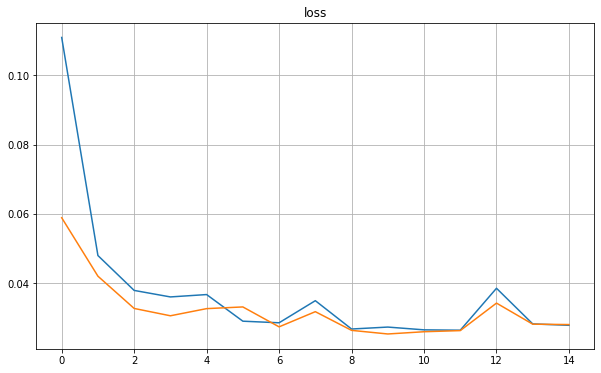

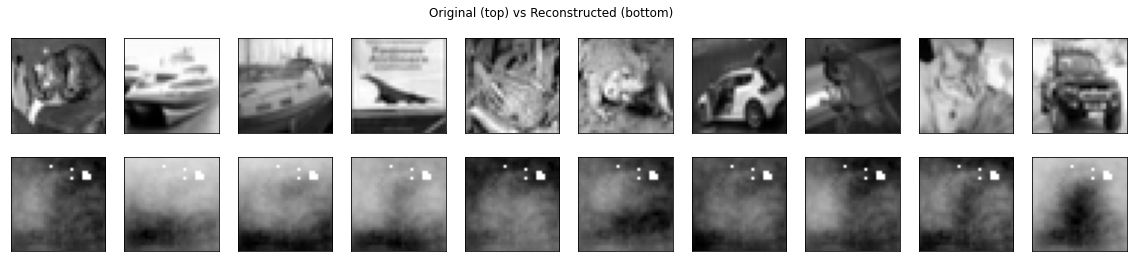

In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='tanh')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_21 (Dense)            (None, 256)               262400    
                                                                 
 dense_22 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0353 - val_loss: 0.0222
Epoch 2/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0196 - val_loss: 0.0184
Epoch 3/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0132
Epoch 4/15
79/79 [=====

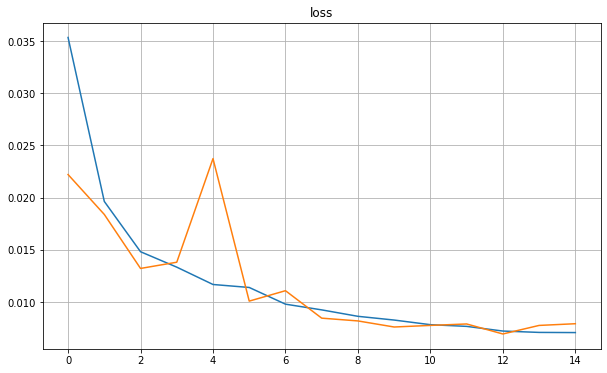

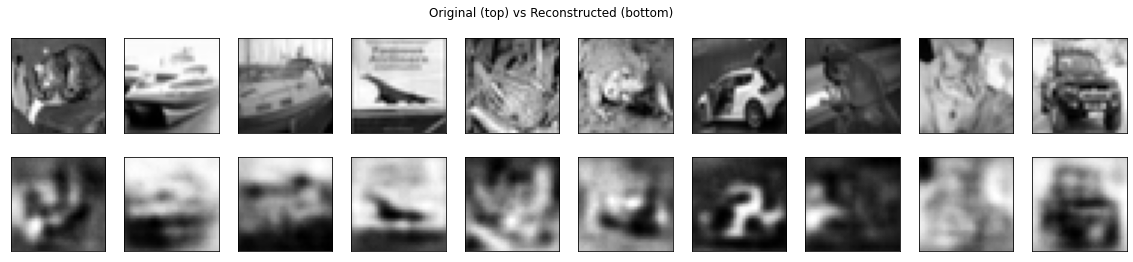

In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_23 (Dense)            (None, 256)               262400    
                                                                 
 dense_24 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 7ms/step - loss: 0.1591 - val_loss: 0.0993
Epoch 2/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0936 - val_loss: 0.0878
Epoch 3/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0776 - val_loss: 0.0701
Epoch 4/15
79/79 [====

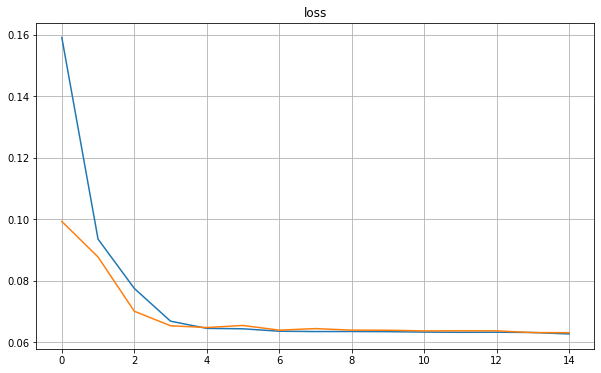

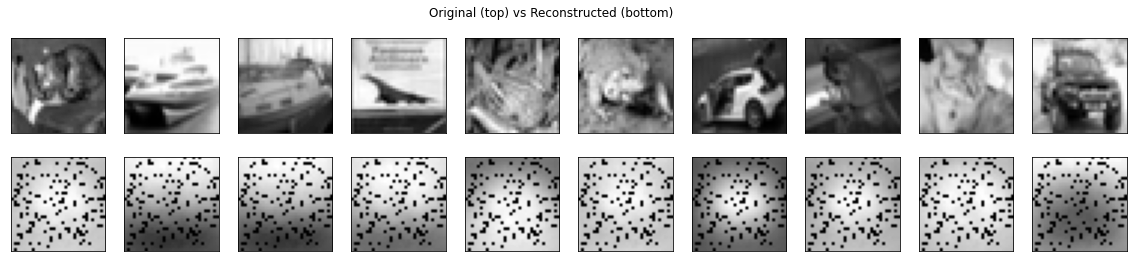

In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='relu')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_25 (Dense)            (None, 256)               262400    
                                                                 
 dense_26 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.0880 - val_loss: 0.0262
Epoch 2/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0220 - val_loss: 0.0191
Epoch 3/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0178 - val_loss: 0.0164
Epoch 4/15
79/79 [====

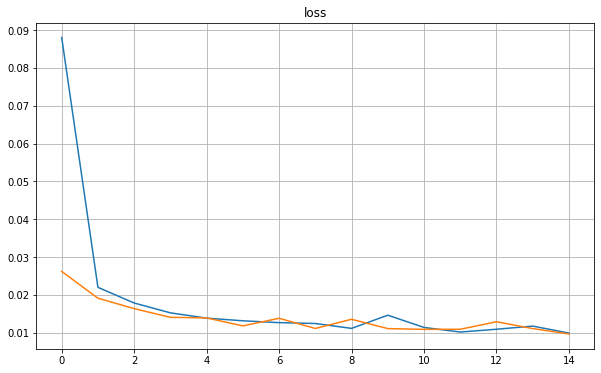

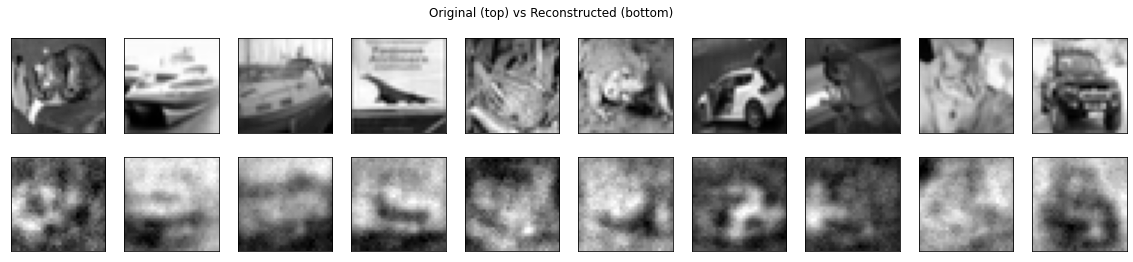

In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='elu')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='elu')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

I tried 4 activation functions: tanh, sigmoid, relu and elu. The best one is sigmoid with an error of $0.00631$, while the other activation functions are very bad and reach the following scores: $0.02526$ (tanh), $0.04643$ (relu) and $0.01226$ (elu).

The non-linear autoencoder with sigmoid achieves a worse error compared to the linear autoencoder, giving a more blurred image as result. Anyway, sigmoid is the function whose behaviour is more linear than the other three functions that I tried, so the obtained result is coherent with the previous one.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

dim = INPUT_DIM

encoded = tf.keras.layers.Dense(dim, activation='relu')(input_img)
dim //= 2
encoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)
dim //= 2
encoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)
dim //= 2
encoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)
dim //= 2
encoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)
dim //= 2
encoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)
dim //= 2
encoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)

dim *= 2
decoded = tf.keras.layers.Dense(dim, activation='relu')(encoded)
dim *= 2
decoded = tf.keras.layers.Dense(dim, activation='relu')(decoded)
dim *= 2
decoded = tf.keras.layers.Dense(dim, activation='relu')(decoded)
dim *= 2
decoded = tf.keras.layers.Dense(dim, activation='relu')(decoded)
dim *= 2
decoded = tf.keras.layers.Dense(dim, activation='relu')(decoded)
dim *= 2
decoded = tf.keras.layers.Dense(dim, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_56 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_57 (Dense)            (None, 512)               524800    
                                                                 
 dense_58 (Dense)            (None, 256)               131328    
                                                                 
 dense_59 (Dense)            (None, 128)               32896     
                                                                 
 dense_60 (Dense)            (None, 64)                8256      
                                                                 
 dense_61 (Dense)            (None, 32)                208

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=25, batch_size=128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/25
313/313 [==============================] - 2s 6ms/step - loss: 0.0360 - val_loss: 0.0321
Epoch 2/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0305 - val_loss: 0.0278
Epoch 3/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0275 - val_loss: 0.0275
Epoch 4/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0270 - val_loss: 0.0260
Epoch 5/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0256 - val_loss: 0.0255
Epoch 6/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0251 - val_loss: 0.0252
Epoch 7/25
313/313 [==============================] - 2s 6ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 8/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0234 - val_loss: 0.0235
Epoch 9/25
313/313 [==============================] - 2s 5ms/step - loss: 0.0231 - val_loss: 0.0232
Epoch 10/25
313/313 [==============================] - 2s 6ms/step - loss: 0.0223 - val_loss: 0.0218

313/313 - 1s - loss: 0.0187 - 668ms/epoch - 2ms/step
test mse: 0.01868


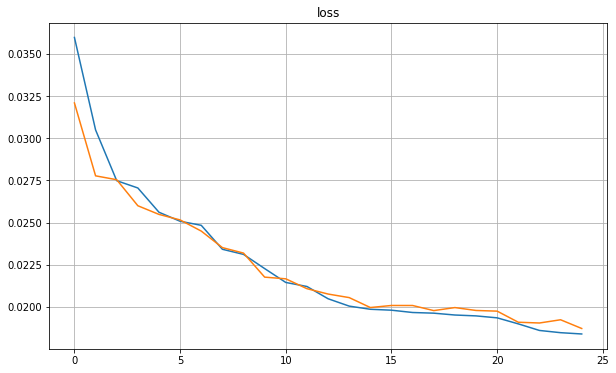

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

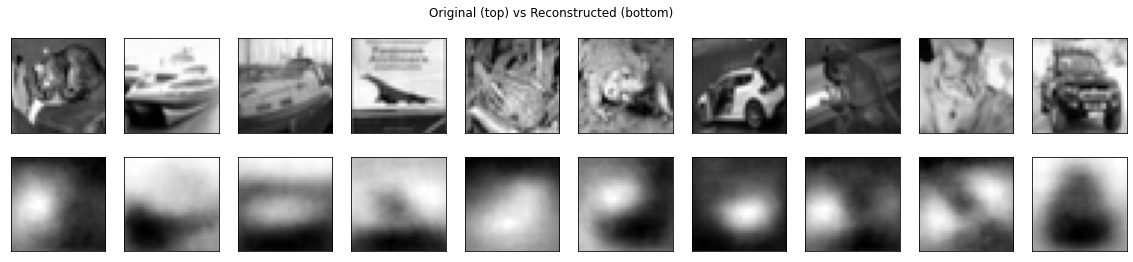

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

After many attempts, I end up with this version of the deep autoencoder made up by 9 layers, whose activation function is relu except for the last one which is sigmoid. Note that I lowered the learning rate from $0.005$ to $0.002$ to get better performance.

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 512

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], "Noisy (top) vs Original (middle) vs Decoded (bottom)")

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

After many attempts, I come up with the model you can find here above where the activation function of the LSTM layer is tanh and the one for the decoder layer is sigmoid. The tanh activation function has been chosen through a trial and error method, while the sigmoid one has been chosen thanks to the fact that the loss function is binary_crossentropy and the ouput is a vector of values which belong to $[0, 1]$.